In [11]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from tqdm import tqdm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
custom_transform = transforms.Compose([transforms.ToTensor(),])
train_data = FashionMNIST(
    root="../data/FashinMNIST",
    # TODO: your arbitrary path
    train=True,
    download=True,
    transform=custom_transform
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

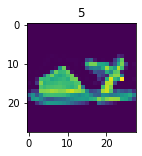

In [13]:
for imgs, labels in train_loader:
    if labels[0] == 5:
        plt.figure(figsize=(2, 2))
        plt.imshow(imgs[0][0])
        plt.title(f"{labels[0]}")
        break

In [14]:
# Training parameters
learning_rate = 0.0002
batch_size = 128
epochs = 100
# TODO: Increase

# Network parameters
image_dim = 784
y_dimension = 10
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100

In [15]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, y_dimension, disc_hidd_dim):
        super().__init__()
        self.fc1 = nn.Linear(image_dim+y_dimension, disc_hidd_dim)
        self.fc2 = nn.Linear(disc_hidd_dim, 1)
    
    def forward(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        out = F.relu(self.fc1(x_y))
        out = self.fc2(out)
        return torch.sigmoid(out)

In [16]:
class Generator(nn.Module):
    def __init__(self, z_noise_dim, y_dimension, gen_hidd_dim, image_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_noise_dim+y_dimension, gen_hidd_dim)
        self.fc2 = nn.Linear(gen_hidd_dim, image_dim)
    
    def forward(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        out = F.relu(self.fc1(x_y))
        out = self.fc2(out)
        return torch.sigmoid(out)

In [17]:
generator = Generator(z_noise_dim, y_dimension, gen_hidd_dim, image_dim).to(DEVICE)
discriminator = Discriminator(image_dim, y_dimension, disc_hidd_dim).to(DEVICE)
criterion =  nn.BCELoss()

gen_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

<ipython-input-213-b0e938f80aff>:3: RuntimeWarning: divide by zero encountered in log
  y = [np.log(j) for j in x]


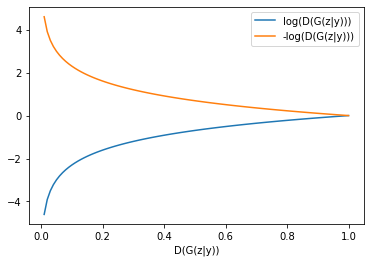

In [213]:
import numpy as np
x = [i/100 for i in range(0, 101, 1)]
y = [np.log(j) for j in x]
plt.plot(x, y, label="log(D(G(z|y)))")
plt.xlabel("D(G(z|y))")

minus_y = [-k for k  in y]
plt.plot(x, minus_y, label="-log(D(G(z|y)))")
plt.legend()

In [18]:
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        y_onehot = torch.nn.functional.one_hot(y, y_dimension).to(DEVICE)
        z = torch.randn(y.shape[0], z_noise_dim).to(DEVICE)
        x = x.reshape(-1, 28*28).to(DEVICE)
        
        # Train Discriminator
        # max(D): log(D(x|y)) + log(1-D(G(z|y)))
        gen_out = generator(z, y_onehot)
        disc_out_fake = discriminator(gen_out, y_onehot)
        disc_out_real = discriminator(x, y_onehot)

        loss_D = criterion(disc_out_real, torch.ones_like(disc_out_real))
        loss_D += criterion(disc_out_fake, torch.zeros_like(disc_out_fake))
        disc_optimizer.zero_grad()
        loss_D.backward(retain_graph=True)
        disc_optimizer.step()
        
        # Train Generator
        # min(G): log(1-D(G(z|y))) <--> max(G): log(D(G(z|y))
        # The latter says fooling D using G
        disc_out_fake = discriminator(gen_out, y_onehot)
        loss_G = criterion(disc_out_fake, torch.ones_like(disc_out_fake))
        # loss_G: -log(D(G(z|y))

        gen_optimizer.zero_grad()
        loss_G.backward()
        gen_optimizer.step()
    print(f"Epoch:{epoch}, Loss:{loss_D}")

100%|██████████| 469/469 [00:05<00:00, 88.24it/s]


Epoch:0, Loss:0.18847522139549255


100%|██████████| 469/469 [00:05<00:00, 87.82it/s]


Epoch:1, Loss:0.4077181816101074


100%|██████████| 469/469 [00:05<00:00, 89.11it/s]


Epoch:2, Loss:0.2999109625816345


100%|██████████| 469/469 [00:05<00:00, 90.23it/s]


Epoch:3, Loss:0.1483754813671112


100%|██████████| 469/469 [00:05<00:00, 90.60it/s]


Epoch:4, Loss:0.07196125388145447


100%|██████████| 469/469 [00:05<00:00, 92.02it/s]


Epoch:5, Loss:0.6841138005256653


100%|██████████| 469/469 [00:05<00:00, 88.78it/s]


Epoch:6, Loss:0.33595573902130127


100%|██████████| 469/469 [00:05<00:00, 90.42it/s]


Epoch:7, Loss:0.13969045877456665


100%|██████████| 469/469 [00:05<00:00, 90.36it/s]


Epoch:8, Loss:0.11987347155809402


100%|██████████| 469/469 [00:05<00:00, 92.47it/s]


Epoch:9, Loss:0.2110683172941208


100%|██████████| 469/469 [00:05<00:00, 92.75it/s]


Epoch:10, Loss:0.1704685389995575


100%|██████████| 469/469 [00:05<00:00, 89.69it/s]


Epoch:11, Loss:0.2780414819717407


100%|██████████| 469/469 [00:05<00:00, 90.46it/s]


Epoch:12, Loss:0.25331318378448486


100%|██████████| 469/469 [00:05<00:00, 90.79it/s]


Epoch:13, Loss:0.33269864320755005


100%|██████████| 469/469 [00:05<00:00, 93.73it/s]


Epoch:14, Loss:0.1576668918132782


100%|██████████| 469/469 [00:05<00:00, 93.74it/s]


Epoch:15, Loss:0.22483515739440918


100%|██████████| 469/469 [00:04<00:00, 94.04it/s]


Epoch:16, Loss:0.2035502791404724


100%|██████████| 469/469 [00:05<00:00, 93.74it/s]


Epoch:17, Loss:0.19676518440246582


100%|██████████| 469/469 [00:05<00:00, 93.67it/s]


Epoch:18, Loss:0.4927125573158264


100%|██████████| 469/469 [00:05<00:00, 93.70it/s]


Epoch:19, Loss:0.38718023896217346


100%|██████████| 469/469 [00:05<00:00, 93.31it/s]


Epoch:20, Loss:0.2613917589187622


100%|██████████| 469/469 [00:05<00:00, 91.36it/s]


Epoch:21, Loss:0.4274812638759613


100%|██████████| 469/469 [00:05<00:00, 89.57it/s]


Epoch:22, Loss:0.48330575227737427


100%|██████████| 469/469 [00:05<00:00, 84.58it/s]


Epoch:23, Loss:0.30794432759284973


100%|██████████| 469/469 [00:05<00:00, 89.27it/s]


Epoch:24, Loss:0.5081703066825867


100%|██████████| 469/469 [00:05<00:00, 93.10it/s]


Epoch:25, Loss:0.5488752722740173


100%|██████████| 469/469 [00:04<00:00, 94.20it/s]


Epoch:26, Loss:0.5839700698852539


100%|██████████| 469/469 [00:04<00:00, 94.44it/s]


Epoch:27, Loss:0.5011091828346252


100%|██████████| 469/469 [00:04<00:00, 93.88it/s]


Epoch:28, Loss:0.4126114249229431


100%|██████████| 469/469 [00:04<00:00, 93.95it/s]


Epoch:29, Loss:0.43593287467956543


100%|██████████| 469/469 [00:04<00:00, 94.47it/s]


Epoch:30, Loss:0.5257765650749207


100%|██████████| 469/469 [00:04<00:00, 94.37it/s]


Epoch:31, Loss:0.4520642161369324


100%|██████████| 469/469 [00:05<00:00, 91.29it/s]


Epoch:32, Loss:0.561843752861023


100%|██████████| 469/469 [00:05<00:00, 88.16it/s]


Epoch:33, Loss:0.6813632845878601


100%|██████████| 469/469 [00:05<00:00, 90.23it/s]


Epoch:34, Loss:0.5906345844268799


100%|██████████| 469/469 [00:05<00:00, 92.62it/s]


Epoch:35, Loss:0.4575246274471283


100%|██████████| 469/469 [00:05<00:00, 92.90it/s]


Epoch:36, Loss:0.47956469655036926


100%|██████████| 469/469 [00:05<00:00, 93.04it/s]


Epoch:37, Loss:0.7382780909538269


100%|██████████| 469/469 [00:05<00:00, 93.08it/s]


Epoch:38, Loss:0.5891627669334412


100%|██████████| 469/469 [00:05<00:00, 92.92it/s]


Epoch:39, Loss:0.5132187604904175


100%|██████████| 469/469 [00:04<00:00, 95.01it/s]


Epoch:40, Loss:0.810633659362793


100%|██████████| 469/469 [00:04<00:00, 94.80it/s]


Epoch:41, Loss:1.074560523033142


100%|██████████| 469/469 [00:04<00:00, 96.01it/s]


Epoch:42, Loss:0.8019425272941589


100%|██████████| 469/469 [00:04<00:00, 95.97it/s]


Epoch:43, Loss:0.7488434314727783


100%|██████████| 469/469 [00:04<00:00, 95.41it/s]


Epoch:44, Loss:0.8289335370063782


100%|██████████| 469/469 [00:04<00:00, 95.87it/s]


Epoch:45, Loss:0.7971988916397095


100%|██████████| 469/469 [00:04<00:00, 93.99it/s]


Epoch:46, Loss:1.134568691253662


100%|██████████| 469/469 [00:05<00:00, 93.46it/s]


Epoch:47, Loss:1.1551843881607056


100%|██████████| 469/469 [00:04<00:00, 94.15it/s]


Epoch:48, Loss:0.8059098720550537


100%|██████████| 469/469 [00:04<00:00, 94.27it/s]


Epoch:49, Loss:0.6718431115150452


100%|██████████| 469/469 [00:04<00:00, 94.29it/s]


Epoch:50, Loss:0.8023953437805176


100%|██████████| 469/469 [00:04<00:00, 94.54it/s]


Epoch:51, Loss:0.9732769727706909


100%|██████████| 469/469 [00:05<00:00, 91.49it/s]


Epoch:52, Loss:0.8963577747344971


100%|██████████| 469/469 [00:05<00:00, 91.29it/s]


Epoch:53, Loss:1.1510009765625


100%|██████████| 469/469 [00:05<00:00, 92.71it/s]


Epoch:54, Loss:0.8760136961936951


100%|██████████| 469/469 [00:04<00:00, 94.36it/s]


Epoch:55, Loss:1.0404714345932007


100%|██████████| 469/469 [00:04<00:00, 93.84it/s]


Epoch:56, Loss:1.1205096244812012


100%|██████████| 469/469 [00:04<00:00, 93.81it/s]


Epoch:57, Loss:0.7216112613677979


100%|██████████| 469/469 [00:04<00:00, 94.18it/s]


Epoch:58, Loss:1.1339409351348877


100%|██████████| 469/469 [00:05<00:00, 92.66it/s]


Epoch:59, Loss:0.8356677293777466


100%|██████████| 469/469 [00:05<00:00, 91.34it/s]


Epoch:60, Loss:0.7071788311004639


100%|██████████| 469/469 [00:05<00:00, 91.39it/s]


Epoch:61, Loss:0.9275834560394287


100%|██████████| 469/469 [00:05<00:00, 91.83it/s]


Epoch:62, Loss:0.9865956902503967


100%|██████████| 469/469 [00:05<00:00, 91.38it/s]


Epoch:63, Loss:1.0870506763458252


100%|██████████| 469/469 [00:05<00:00, 90.01it/s]


Epoch:64, Loss:1.1492009162902832


100%|██████████| 469/469 [00:05<00:00, 89.85it/s]


Epoch:65, Loss:0.8154997229576111


100%|██████████| 469/469 [00:05<00:00, 89.48it/s]


Epoch:66, Loss:1.2031385898590088


100%|██████████| 469/469 [00:05<00:00, 88.94it/s]


Epoch:67, Loss:0.909511148929596


100%|██████████| 469/469 [00:05<00:00, 89.39it/s]


Epoch:68, Loss:1.061665654182434


100%|██████████| 469/469 [00:05<00:00, 88.91it/s]


Epoch:69, Loss:0.8963868618011475


100%|██████████| 469/469 [00:05<00:00, 90.17it/s]


Epoch:70, Loss:0.8111565113067627


100%|██████████| 469/469 [00:05<00:00, 89.95it/s]


Epoch:71, Loss:0.8443441390991211


100%|██████████| 469/469 [00:04<00:00, 94.57it/s]


Epoch:72, Loss:0.7617251873016357


100%|██████████| 469/469 [00:05<00:00, 92.99it/s]


Epoch:73, Loss:0.9770128726959229


100%|██████████| 469/469 [00:05<00:00, 89.76it/s]


Epoch:74, Loss:0.9279632568359375


100%|██████████| 469/469 [00:05<00:00, 91.07it/s]


Epoch:75, Loss:0.858491837978363


100%|██████████| 469/469 [00:05<00:00, 91.40it/s]


Epoch:76, Loss:1.058626651763916


100%|██████████| 469/469 [00:05<00:00, 90.72it/s]


Epoch:77, Loss:0.8842199444770813


100%|██████████| 469/469 [00:05<00:00, 91.25it/s]


Epoch:78, Loss:1.0267891883850098


100%|██████████| 469/469 [00:05<00:00, 90.77it/s]


Epoch:79, Loss:0.7468166947364807


100%|██████████| 469/469 [00:05<00:00, 89.43it/s]


Epoch:80, Loss:0.9587162733078003


100%|██████████| 469/469 [00:05<00:00, 89.64it/s]


Epoch:81, Loss:0.872480034828186


100%|██████████| 469/469 [00:05<00:00, 90.21it/s]


Epoch:82, Loss:1.113458514213562


100%|██████████| 469/469 [00:05<00:00, 88.94it/s]


Epoch:83, Loss:1.1576051712036133


100%|██████████| 469/469 [00:05<00:00, 93.12it/s]


Epoch:84, Loss:1.1116693019866943


100%|██████████| 469/469 [00:05<00:00, 92.68it/s]


Epoch:85, Loss:0.8793266415596008


100%|██████████| 469/469 [00:05<00:00, 91.98it/s]


Epoch:86, Loss:1.0890223979949951


100%|██████████| 469/469 [00:05<00:00, 90.22it/s]


Epoch:87, Loss:1.0545823574066162


100%|██████████| 469/469 [00:05<00:00, 89.66it/s]


Epoch:88, Loss:0.9641635417938232


100%|██████████| 469/469 [00:05<00:00, 92.83it/s]


Epoch:89, Loss:1.1761442422866821


100%|██████████| 469/469 [00:05<00:00, 92.89it/s]


Epoch:90, Loss:1.052098035812378


100%|██████████| 469/469 [00:05<00:00, 88.79it/s]


Epoch:91, Loss:1.4779350757598877


100%|██████████| 469/469 [00:04<00:00, 93.87it/s]


Epoch:92, Loss:1.0585476160049438


100%|██████████| 469/469 [00:05<00:00, 87.91it/s]


Epoch:93, Loss:1.0704970359802246


100%|██████████| 469/469 [00:05<00:00, 87.63it/s]


Epoch:94, Loss:1.1763814687728882


100%|██████████| 469/469 [00:05<00:00, 89.78it/s]


Epoch:95, Loss:0.9712798595428467


100%|██████████| 469/469 [00:05<00:00, 92.30it/s]


Epoch:96, Loss:1.0203711986541748


100%|██████████| 469/469 [00:04<00:00, 94.05it/s]


Epoch:97, Loss:1.1090315580368042


100%|██████████| 469/469 [00:05<00:00, 93.71it/s]


Epoch:98, Loss:1.363640308380127


100%|██████████| 469/469 [00:05<00:00, 92.24it/s]

Epoch:99, Loss:1.0612564086914062


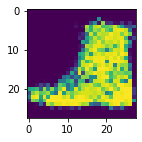

In [226]:
# Eval
z = torch.randn(1, z_noise_dim).to(DEVICE)
y_onehot = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).to(DEVICE).reshape(1, 10)
gen_out = generator(z, y_onehot).cpu().detach().numpy()
plt.figure(figsize=(2,2))
plt.imshow(gen_out.reshape(28, 28))

In [227]:
z

tensor([[ 0.7288,  3.2643, -0.7098, -0.5282,  0.3474,  1.3771, -0.5271, -1.6093,
         -0.4570,  0.2556,  0.9727, -0.1983, -0.9370, -0.7299,  0.1158, -0.3518,
         -0.4014,  2.6792,  0.2898,  0.7478,  1.7611,  0.8047,  0.1162, -0.3539,
         -0.8772,  0.8873,  1.2018,  0.3915, -0.1211,  1.1455, -0.9706, -0.8739,
         -0.3733,  0.4794,  0.7737,  1.5614, -0.9370, -1.7336, -0.3091, -1.4481,
         -0.3623, -0.2680,  1.6237,  0.5051, -0.4023, -0.6644, -0.3313, -0.4981,
         -0.3982,  0.1920,  1.2531,  0.1677, -0.1988,  1.1243,  1.2802,  1.0002,
         -0.0608,  1.6852, -0.8731,  1.0507, -0.4535,  0.1800, -1.5793,  1.0831,
          1.3158,  0.2606,  0.0754, -2.2660, -1.2685, -0.1155, -1.6696, -0.7317,
         -0.2899, -0.2165,  1.0846,  0.6867,  1.5884, -1.0107,  0.6887, -0.0366,
          0.2346,  0.2709,  1.1836, -1.0061, -0.2486, -1.2813,  0.2707, -0.4769,
          0.7733, -0.1171,  0.6205, -0.0869, -0.3436,  0.1245, -0.4503, -1.7212,
         -3.1805,  0.2851, -

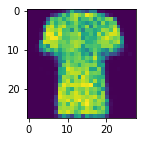

In [218]:
y_onehot = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).to(DEVICE).reshape(1, 10)
gen_out = generator(z, y_onehot).cpu().detach().numpy()
plt.figure(figsize=(2,2))
plt.imshow(gen_out.reshape(28, 28))